In [60]:
!pip install pyDOE

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale
#import seaborn as sns

import torch.nn as nn
import torch.nn.init as init
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from pyDOE import lhs

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc


In [62]:
df = pd.read_csv("/content/Dataset.csv")

In [63]:
df

,Unnamed: 0,G,T1,T2,T3,T4,T5,T6,T7,T8,T9
0,0,0.466437,400.0,398.302558,396.849679,395.634729,394.650520,393.891157,393.352043,393.029891,392.922726
1,1,0.789417,400.0,402.069952,403.829778,405.295777,406.479782,407.391204,408.037205,408.422817,408.551024
2,2,0.618756,400.0,400.043948,400.079881,400.109876,400.134140,400.152842,400.166108,400.174032,400.176667
3,3,0.333827,400.0,396.835856,394.124136,391.853177,390.011353,388.589006,387.578533,386.974455,386.773464
4,4,0.523496,400.0,398.947667,398.047075,397.294456,396.685089,396.215120,395.881560,395.682275,395.615989
...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.123213,400.0,394.596808,389.955218,386.059564,382.894421,380.446724,378.706024,377.664698,377.318108
496,496,0.456705,400.0,398.193376,396.646939,395.353611,394.305818,393.497342,392.923333,392.580317,392.466210
497,497,0.714528,400.0,401.170945,402.166938,402.997402,403.668602,404.185556,404.552107,404.770963,404.843736
498,498,0.290461,400.0,396.365902,393.249919,390.639195,388.521015,386.884773,385.722094,385.026926,384.795612


In [105]:
muestras =  list(range(10,410,10))

In [106]:
xl = []
yl = []
for i in muestras:
    df_m = df.sample(int(i/0.8))
    X = df_m.drop(columns=["G","Unnamed: 0"])
    y = df_m["G"]
    x = X.to_numpy()
    y = y.to_numpy()
    xl.append(x)
    yl.append(y)

In [66]:
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [67]:
class NNet(torch.nn.Module):
  def __init__(self,n, g = None):
    # Defino la arquitectura de la red
    super().__init__()
    self.n = n
    self.G_fun = g
    self.drop = torch.nn.Dropout(p = 0.7)
    self.linear_1 = torch.nn.Linear(in_features=n, out_features=20, bias=True)
    self.relu = torch.nn.ReLU()
    self.linear_2 = torch.nn.Linear(in_features = 20, out_features=20, bias=True)
    self.drop2 = torch.nn.Dropout(p = 0.6)
    self.relu2 = torch.nn.ReLU()
    self.linear_3 = torch.nn.Linear(in_features = 20, out_features=1, bias=True)


  def forward(self, x):
    # Defino el cálculo del paso forward
    x = self.linear_1(x)
    x = self.drop(x)
    x = self.relu(x)
    x = self.linear_2(x)
    x = self.drop2(x)
    x = self.relu2(x)
    x = self.linear_3(x)

    return x

  def Residue(self, x, o):

      G = self.G_fun
      Tx = torch.autograd.grad(o, x, create_graph=True, grad_outputs=torch.ones_like(T))[0]
      Txx = torch.autograd.grad(Tx, x, create_graph=True, grad_outputs=torch.ones_like(T))[0][:, 0:1]
      residue = Txx - o*G*(1+o)
      return residue

##Defino una Red con 9 entradas

In [107]:
nnet = NNet(9)

In [108]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr = 0.001)

In [109]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"
device

'cpu'

In [110]:
nnet = nnet.to(device)

In [111]:
n_muestras = []
error_epoch = []
for x, y in zip(xl,yl):
    X_train, X_test, y_train, y_test= train_test_split(x, y, test_size = 0.2)
    train_ds = MyDataset(X_train, y_train)
    valid_ds = MyDataset(X_test, y_test)
    train_dataloader = DataLoader(train_ds, batch_size = 50)
    valid_dataloader = DataLoader(valid_ds, batch_size= 50)
    n_train = X_train.shape[0]
    n_valid = X_test.shape[0]
    epochs = 30
    train_loss_by_epoch=[]
    valid_loss_by_epoch=[]


    for epoch in range(epochs):
      nnet.train(True)
      epoch_loss = 0
      epoch_y_hat = []
      epoch_y = []

      for i,data in enumerate(train_dataloader):
        x_batch, y_batch = data
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float().reshape(-1, 1)
        optimizer.zero_grad()
        nnet_output = nnet(x_batch)
        loss = loss_function(nnet_output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_y += list(y_batch.detach().cpu().numpy())
        epoch_y_hat += list(nnet_output.detach().cpu().numpy())
        epoch_loss = epoch_loss + loss.item()

      epoch_loss = epoch_loss/n_train
      train_loss_by_epoch.append(epoch_loss)
      error_train = metrics.mean_absolute_percentage_error(epoch_y, epoch_y_hat)

      nnet.train(False)
      valid_epoch_loss = 0
      valid_epoch_y_hat = []
      valid_epoch_y = []

      for i,data in enumerate(valid_dataloader):
        x_batch, y_batch = data
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float().reshape(-1, 1)
        nnet_output = nnet(x_batch)
        loss = loss_function(nnet_output, y_batch)
        valid_epoch_y += list(y_batch.detach().cpu().numpy())
        valid_epoch_y_hat += list(nnet_output.detach().cpu().numpy())
        valid_epoch_loss = valid_epoch_loss + loss.item()
      valid_epoch_loss = valid_epoch_loss/n_valid
      valid_loss_by_epoch.append(valid_epoch_loss)
      error = metrics.mean_squared_error(valid_epoch_y, valid_epoch_y_hat)
    error_epoch.append(error)
    n_muestras.append(len(X_train))
    # Impresión de resultados por epoch

    #print(f" Epoch {epoch} | " \
    #     f"Train/Valid loss: {epoch_loss:.3f} / {valid_epoch_loss:.3f} | " \
    #    f"Train/Valid Error %: {error_train:.1f} / {error:.1f}")

Text(0, 0.5, 'Error')

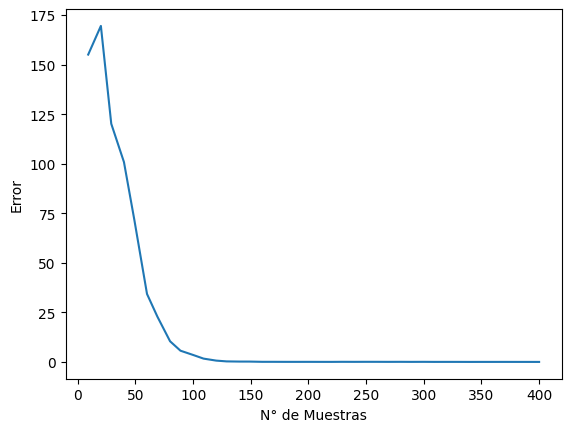

In [112]:
plt.plot(n_muestras,error_epoch)
plt.xlabel("N° de Muestras")
plt.ylabel("Error")

In [74]:
T = df.drop(columns=["G","Unnamed: 0"])
sensores = T.columns.values
#Tnorm = minmax_scale(T.to_numpy(),(27,127))
Temp = T.to_numpy()

#Las condiciones de contorno son para x = 0 theta = 1, caso que se da cuando T = Tb. Para x = 1 T = Tinf.

In [75]:
x0 = 0
x1 = 1
x = np.linspace(x0, x1, 9)

In [76]:
x_tensor = torch.linspace(x0, x1, 10000, device=device)
N_bc = 1000
N_dom = 1000
tags = ["Contorno","Domain","Data"]
ds = []

In [77]:
X_dom = torch.Tensor(lhs(1, N_dom)).to(torch.float32).to(device)
y_dom = torch.zeros((N_dom, 1), device=device)

In [78]:
Tb = 127
Tinf = 27
x_0 = x0*torch.ones((N_bc, 1), device=device)
y_0 = Tb*torch.ones((N_bc, 1), device=device)
idx_bc = np.random.choice(x_tensor.size()[0], N_bc, replace=False)
x_inf = x1*torch.ones((N_bc, 1), device=device)
y_inf = Tinf*torch.ones((N_bc, 1), device=device)
X_con = torch.cat([x_0, x_inf], axis=0)
y_con = torch.cat([y_0, y_inf], axis=0)
ds.append(MyDataset(X_con, y_con))
ds.append(MyDataset(X_dom, y_dom))

In [79]:
Temp = Temp.reshape(4500,1)

In [80]:
sensor_loc = np.linspace(x0, x1, 9)
x_data = []
for p, s in zip(x,sensores):
    x_data.append(torch.full((len(T[s]),1),p))

In [81]:
y_data = torch.Tensor(Temp)
x_data = torch.cat(x_data,axis = 0)
ds.append(MyDataset(x_data, y_data))
datasets = dict(zip(tags, ds))
G = nn.Parameter(torch.tensor(1.0))
tanh = nn.Tanh()
G_fun = lambda x: x*tanh(1e3*x)

In [82]:
nnet_pin = NNet(1,G_fun(G))

In [83]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(list(nnet_pin.parameters()) + [G],
    lr=0.001)

In [84]:
nnet_pin = nnet_pin.to(device)

In [85]:
epochs = 20000
loss_train = []
loss_train_dom = []
loss_train_bc = []
loss_train_ic = []
loss_train_data = []
G_values = []
train_keys = ["Contorno", "Domain","Data"]

for epoch in range(epochs):

    loss_list = []
    for tag in tags:
        X = (datasets[tag].x).detach().to(device)
        y = (datasets[tag].y).to(device)
        if tag=='Domain':
            X.requires_grad = True
            T = nnet_pin(X)
            o = (T-Tinf)/(Tb-Tinf)
            y_hat = nnet_pin.Residue(X, o)
            loss = loss_function(y_hat, y)
            loss_list.append(loss)
        else:
            T = nnet_pin(X)
            loss = loss_function(T, y)
            loss_list.append(loss)
        del X, y

    optimizer.zero_grad()
    loss = sum(loss_list)
    loss.backward()
    optimizer.step()

    # Clamp alpha_input to keep them positive ###REVISAR IMPLEMENTACION!!!!!
    with torch.no_grad():
        G.clamp_(min=0.001)

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    loss_train_data.append(loss_list[2].item())
    loss_list.append(G.item())
    G_values.append(G.item())
    nnet_pin.G_fun = G

    if epoch % 100 == 0:
        print("Epoch:" ,{epoch})
        print("G",G.item())
        #print(f"{train_keys[0] }:{loss_list[0]} ,{train_keys[1]}:{loss_list[1]}, {train_keys[2]}:{loss_list[2]}")
        print(f"{train_keys[0] }:{loss_list[0]} ,{train_keys[1]}:{loss_list[1]}")


Epoch: {0}
G 0.9990000128746033
Contorno:167037.515625 ,Domain:8438.1376953125
Epoch: {100}
G 0.9027066826820374
Contorno:164363.328125 ,Domain:8020.6513671875
Epoch: {200}
G 0.8339108228683472
Contorno:151474.59375 ,Domain:6482.60205078125
Epoch: {300}
G 0.666184663772583
Contorno:123131.6796875 ,Domain:5476.1318359375
Epoch: {400}
G 0.3524762690067291
Contorno:94512.0703125 ,Domain:11416.0322265625
Epoch: {500}
G 0.11391542851924896
Contorno:86505.59375 ,Domain:21323.556640625
Epoch: {600}
G 0.01815524883568287
Contorno:84519.65625 ,Domain:23295.751953125
Epoch: {700}
G 0.0014186151092872024
Contorno:81529.6015625 ,Domain:21973.236328125
Epoch: {800}
G 0.0010000000474974513
Contorno:81051.7421875 ,Domain:22646.02734375
Epoch: {900}
G 0.0010000000474974513
Contorno:80712.3515625 ,Domain:24755.400390625
Epoch: {1000}
G 0.0010000000474974513
Contorno:80163.171875 ,Domain:24234.08984375
Epoch: {1100}
G 0.0010000000474974513
Contorno:76582.109375 ,Domain:22989.44921875
Epoch: {1200}
G 0.0

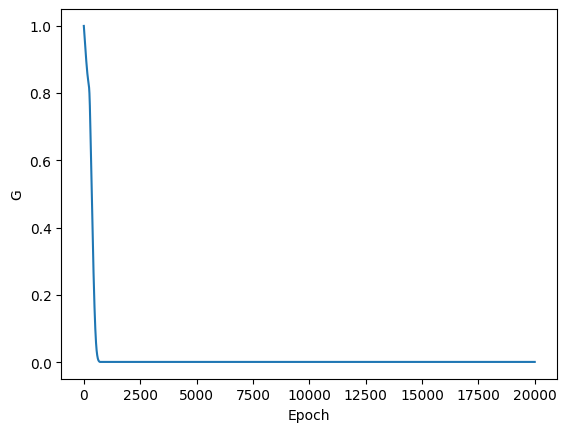

In [114]:
plt.plot(G_values)
plt.xlabel("Epoch")
plt.ylabel("G")
plt.show()

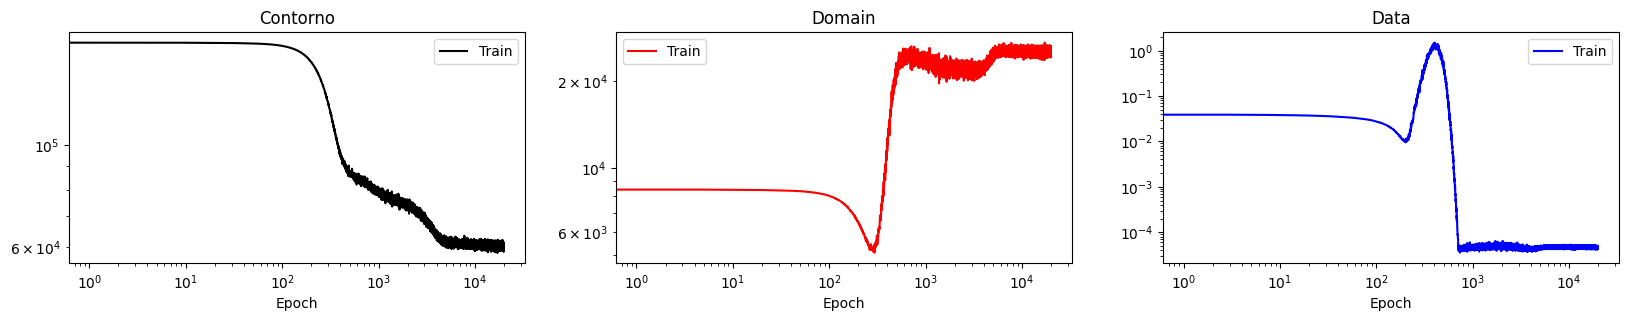

In [87]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom]
colors = ['black', 'red', 'blue']
titles = ["Contorno","Domain", "Data"]

loss_train_list.append(loss_train_data)
colors.append('magenta')
titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].loglog(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()